In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA

In [106]:
# Get the preprocessed X and y from the data.
def get_X_y():
    # Read in data.
    df = pd.read_csv('data/Boats_Cleaned_dataset.csv')
    df = df.fillna(0)

    # Delete selected rows with NaN.
    df = df.drop(df[df['zip']==0].index)
    df = df.drop(df[df['engineCategory']==0].index)
    df = df.drop(df[df['beam_ft']==0].index)
    df = df.drop(df[df['totalHP']==0].index)

    # Delete selected columns with NaN
    df = df.drop(['Unnamed: 0','created_date','id','maxEngineYear','minEngineYear','dryWeight_lb','make','model','city','sellerId','zip'],axis=1)

    # Define features and target.
    X0 = df.drop(['price'], axis=1)
    y0 = df.price

    # Standardize
    X_n = X0.select_dtypes(include='number')
    X_c = X0.select_dtypes(exclude='number')
    X_n = StandardScaler().set_output(transform='pandas').fit_transform(X_n)

    # Hot Encode
    X_c = pd.get_dummies(X_c, drop_first = False) #dropped first
    df = pd.concat([X_n,X_c,y0],axis=1)

    # Redefine features and target
    X = df.drop(['price'],axis=1)
    y = df.price

    return (X, y)

In [107]:
X, y = get_X_y()
print(X.shape)

(5765, 141)


In [108]:
X.columns

Index(['year', 'length_ft', 'beam_ft', 'numEngines', 'totalHP',
       'created_month', 'created_year', 'type_power', 'type_sail',
       'boatClass_power-aft',
       ...
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA',
       'state_VT', 'state_WA', 'state_WI', 'state_WV'],
      dtype='object', length=141)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# standardize features and convert back to dataframe
stnd = StandardScaler().set_output(transform='pandas')
X_train = stnd.fit_transform(X_train)
X_test = stnd.transform(X_test)

In [123]:
stnd = StandardScaler().set_output(transform='pandas')

poly = PolynomialFeatures(2,interaction_only=False,include_bias=False)
Xe_train = poly.fit_transform(X_train)
cols = poly.get_feature_names_out(X_train.columns)
Xe_train = pd.DataFrame(Xe_train, columns=cols)
Xe_train = stnd.fit_transform(Xe_train)
Xe_train['bias'] = 1
print(Xe_train.shape)
Xe_train.head()

Xe_test = poly.fit_transform(X_test)
cols = poly.get_feature_names_out(X_test.columns)
Xe_test = pd.DataFrame(Xe_test, columns=cols)
Xe_test = stnd.transform(Xe_test)
Xe_test['bias'] = 1
Xe_test.head()

(4612, 10153)


,year,length_ft,beam_ft,numEngines,totalHP,created_month,created_year,type_power,type_sail,boatClass_power-aft,...,state_VT state_WA,state_VT state_WI,state_VT state_WV,state_WA^2,state_WA state_WI,state_WA state_WV,state_WI^2,state_WI state_WV,state_WV^2,bias
0,0.347915,-1.418005,-1.382239,-0.377222,-0.444083,-0.927107,0.675272,0.140275,-0.140275,-0.038988,...,0.080044,0.081728,0.056995,-0.140275,0.232222,0.075235,-0.198598,0.076628,-0.038988,1
1,0.551439,0.198903,-0.044838,-0.377222,-0.015036,1.487757,0.675272,0.140275,-0.140275,-0.038988,...,-1.993894,0.081728,0.056995,7.128831,-5.784667,-1.874110,-0.198598,0.076628,-0.038988,1
2,0.449677,-0.372590,-0.044838,-0.377222,-0.472686,-0.323391,0.675272,0.140275,-0.140275,-0.038988,...,0.080044,0.081728,0.056995,-0.140275,0.232222,0.075235,-0.198598,0.076628,-0.038988,1
3,0.449677,-0.632068,-0.159006,-0.377222,-0.401178,1.185899,-0.443390,0.140275,-0.140275,-0.038988,...,0.080044,-0.995210,0.056995,-0.140275,-2.827796,0.075235,5.035304,-0.933113,-0.038988,1
4,0.449677,-0.658873,-0.316667,-0.377222,-0.401178,-0.323391,0.675272,0.140275,-0.140275,-0.038988,...,0.080044,0.081728,0.056995,-0.140275,0.232222,0.075235,-0.198598,0.076628,-0.038988,1


In [130]:
# regularize
grid = {'alpha':[0.01,0.1,1,10,100,1000,10000]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
lassoCV.fit(Xe_train,y_train)

print()
print('best alpha =',lassoCV.best_params_, '  valid R2 =',lassoCV.best_score_.round(3))

C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+12, tolerance: 1.550e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+12, tolerance: 1.739e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+11, tolerance: 1.607e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.667e+11, tolerance: 1.283e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi


best alpha = {'alpha': 1000}   valid R2 = 0.802


fuelType_0 fuelType_diesel               -15351.593237
length_ft hullMaterial_aluminum          -12373.021992
condition_new fuelType_0                 -11767.932420
totalHP boatClass_power-expresscruiser   -10971.743144
created_year boatClass_power-mega        -10785.656188
                                              ...     
length_ft                                 38787.254807
fuelType_diesel                           40104.775233
totalHP                                   45243.649305
condition_new fuelType_diesel             58828.323221
year totalHP                              77622.406496
Length: 10153, dtype: float64

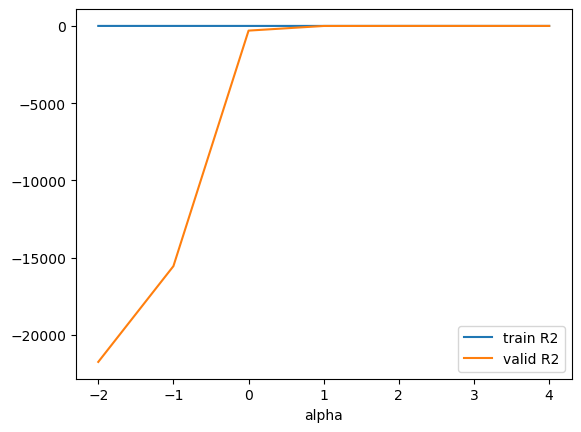

In [131]:
results = pd.DataFrame()
results['alpha'] = np.log10(grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['valid R2']  = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index=Xe_train.columns)
coef.sort_values()

In [133]:
print('Test R2: ', lassoCV.score(Xe_test,y_test))

Test R2:  0.8433002862982288
